In [ ]:
pip install nvidia-ml-py3


  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19173 sha256=c3d590f4168d97fa38da2bdeace30ff1af905b0df8525318e95f3083b1a7185c
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3


In [ ]:
#In order to test the DCT layer in ResNet input layer, first we will test the base model
#To do that, we will use the pre-trained ResNet-50 model from tensorflow library
#This model is already trained with Image-Net so it will be a good enough indicator

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import Model, Input,Layer

# Load pre-trained ResNet-50 model
#werights= "imagenet" it is trained with imagenet
model = ResNet50(weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#we will implement a custom discrete cosine transform layer
class DiscreteCosineTransform2D(Layer):
  def __init__(self, **kwargs):
    super(DiscreteCosineTransform2D, self).__init__(**kwargs)

    #we need a call function

  def call(self,inputs):
    #input size [batch, height, width, channels]
    #we will do a 2D discrete cosine transform on height and then width

    #first, dct along the width axis 1
    #because tensorflow doesnt support axis 1 as we have mentioned above
    #we need to transpose
    #[B,H,W,C] --> [B,H,C,W]
    x = tf.transpose(inputs, [0,1,3,2])
    #then we apply the DCT along the last axis which is W
    x = tf.signal.dct(x, type =2, axis =-1, norm= "ortho")
    #transpose back
    x = tf.transpose(x, [0,1,3,2])
    #now its turned into [B,H,W,C]

    #We have completed the DCT transform on width
    #Now we have to do along the height
    #same as above [B,H,W,C] -> [B,W,C,H]
    x = tf.transpose(x, [0,2,3,1])
    #Apply DCT along last axis (height)
    x = tf.signal.dct(x, type =2, axis =-1, norm= "ortho")
    #Now back to the original order
    x = tf.transpose(x, [0,3,1,2])


Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.3546 - loss: 2.6215Epoch 1: GPU Utilization = 5%, Memory Usage = 25531.19 MB, Power Usage = 70.36 W
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 278ms/step - accuracy: 0.3550 - loss: 2.6195 - val_accuracy: 0.3816 - val_loss: 2.3892
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6420 - loss: 1.2314Epoch 2: GPU Utilization = 90%, Memory Usage = 25587.19 MB, Power Usage = 77.86 W
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 159ms/step - accuracy: 0.6422 - loss: 1.2310 - val_accuracy: 0.5353 - val_loss: 1.8551
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7490 - loss: 0.8181Epoch 3: GPU Utilization = 52%, Memory Usage = 25587.19 MB, Power Usage = 78.53 W
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 159ms/step - accuracy: 0.7491 - loss: 0.8178 - val_accuracy: 0.5964 - val_loss: 1.5637
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8395 - loss: 0.5180Epoch 4: GPU Utilization = 71%, Memory Usage =

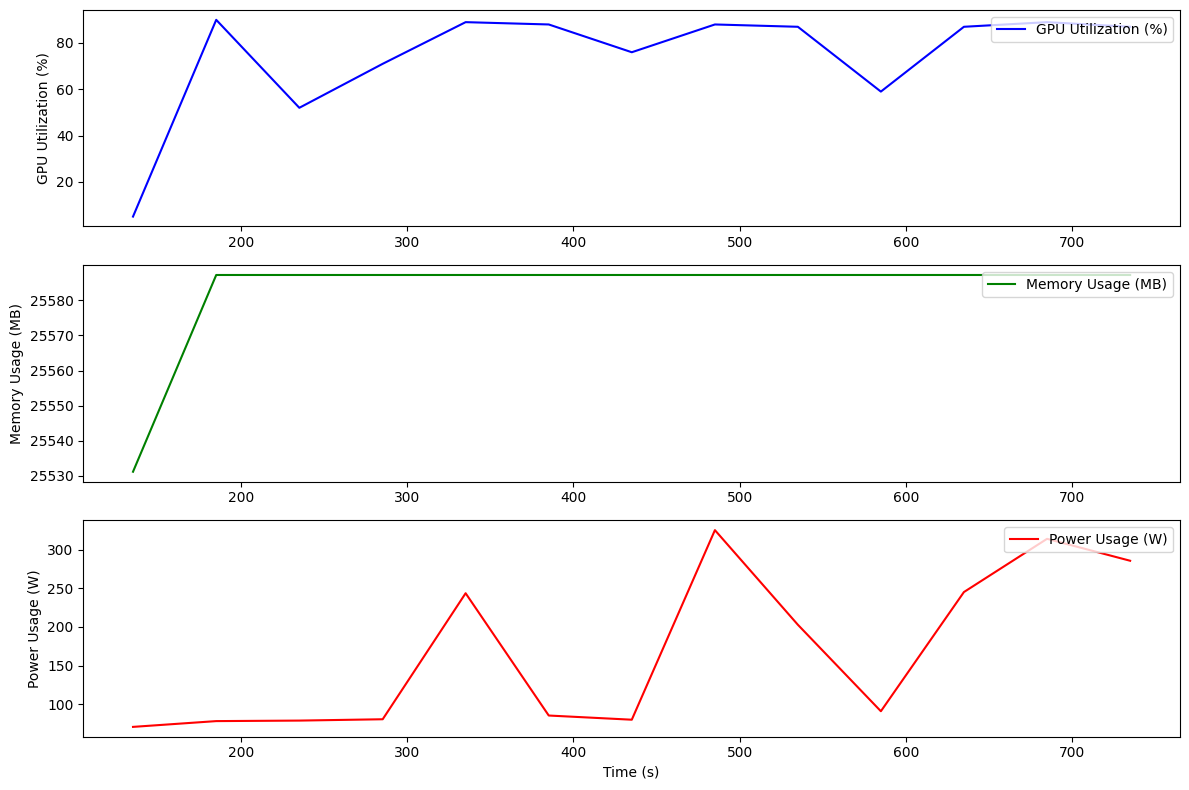

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback
import pynvml
import time
import matplotlib.pyplot as plt
import numpy as np

# We will be using pynvml.nvmlInit() for monitoring the gpu consumption
# Because we have to work directly on the GPU,
pynvml.nvmlInit()  # Initialize NVML
gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)
# This code prioritizes the GPU

# Loading the CIFAR-100 dataset from TFDS like in our base case
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'cifar100',
    split=['train[:80%]', 'train[80%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Getting the number of classes
# We are utilizing CIFAR-100 dataset which consists of 100 classes
# We can just assign num_classes = 100 but in order to maintain the overall structure
num_classes = ds_info.features['label'].num_classes  # Should be 100 for CIFAR-100
# This takes the number of classes by using .info()

# Loading the model
def preprocess(image, label):
    # CIFAR-100 images are 32x32 RGB, need to be resized to 224x224 for ResNet
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(tf.cast(image, tf.float32))
    return image, label

batch_size = 128

# Create the training, validation, and test datasets
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create a model with ResNet50 base
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Now we have to monitor GPU Callback
# Creating a class
class GPUMonitorCallback(Callback):
    def __init__(self):
        super().__init__()
        self.gpu_utilizations = []
        self.memory_usages = []
        self.power_usages = []
        self.timestamps = []
        self.start_time = None

    # To log the start time each epoch
    def on_train_begin(self, logs=None):
        # Getting the start time
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        # Collect GPU metrics
        elapsed_time = time.time() - self.start_time
        gpu_usage = pynvml.nvmlDeviceGetUtilizationRates(gpu_handle).gpu
        memory_details = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
        memory_consumed = memory_details.used / 1024**2  # Convert to MB
        power_consumption = pynvml.nvmlDeviceGetPowerUsage(gpu_handle) / 1000  # Convert to Watts

        # Append metrics to lists
        self.timestamps.append(elapsed_time)
        self.gpu_utilizations.append(gpu_usage)
        self.memory_usages.append(memory_consumed)
        self.power_usages.append(power_consumption)

        print(f"Epoch {epoch + 1}: GPU Utilization = {gpu_usage}%, Memory Usage = {memory_consumed:.2f} MB, Power Usage = {power_consumption:.2f} W")

    def plot_metrics(self):
        # Plot GPU Metrics
        plt.figure(figsize=(12, 8))

        # GPU Utilization Plot
        plt.subplot(3, 1, 1)
        plt.plot(self.timestamps, self.gpu_utilizations, label='GPU Utilization (%)', color='blue')
        plt.ylabel('GPU Utilization (%)')
        plt.legend(loc='upper right')

        # Memory Usage Plot
        plt.subplot(3, 1, 2)
        plt.plot(self.timestamps, self.memory_usages, label='Memory Usage (MB)', color='green')
        plt.ylabel('Memory Usage (MB)')
        plt.legend(loc='upper right')

        # Power Usage Plot
        plt.subplot(3, 1, 3)
        plt.plot(self.timestamps, self.power_usages, label='Power Usage (W)', color='red')
        plt.xlabel('Time (s)')
        plt.ylabel('Power Usage (W)')
        plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

# Initialize GPU Monitor Callback
gpu_monitor = GPUMonitorCallback()

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Train the model with callbacks
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=50,
    callbacks=[early_stopping, gpu_monitor]
)

# Evaluate the model on the test set
model.evaluate(ds_test)

# Plot GPU metrics
gpu_monitor.plot_metrics()

# Shutdown NVML after training
pynvml.nvmlShutdown()


Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.2560 - loss: 3.1693Epoch 1: GPU Utilization = 7%, Memory Usage = 25597.19 MB, Power Usage = 53.20 W
313/313 ━━━━━━━━━━━━━━━━━━━━ 124s 239ms/step - accuracy: 0.2564 - loss: 3.1670 - val_accuracy: 0.3648 - val_loss: 2.6855
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5612 - loss: 1.5754Epoch 2: GPU Utilization = 76%, Memory Usage = 25597.19 MB, Power Usage = 77.86 W
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 159ms/step - accuracy: 0.5614 - loss: 1.5750 - val_accuracy: 0.5039 - val_loss: 1.9232
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6709 - loss: 1.1458Epoch 3: GPU Utilization = 51%, Memory Usage = 25597.19 MB, Power Usage = 81.05 W
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 159ms/step - accuracy: 0.6709 - loss: 1.1456 - val_accuracy: 0.5974 - val_loss: 1.4783
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7471 - loss: 0.8584Epoch 4: GPU Utilization = 90%, Memory Usage =

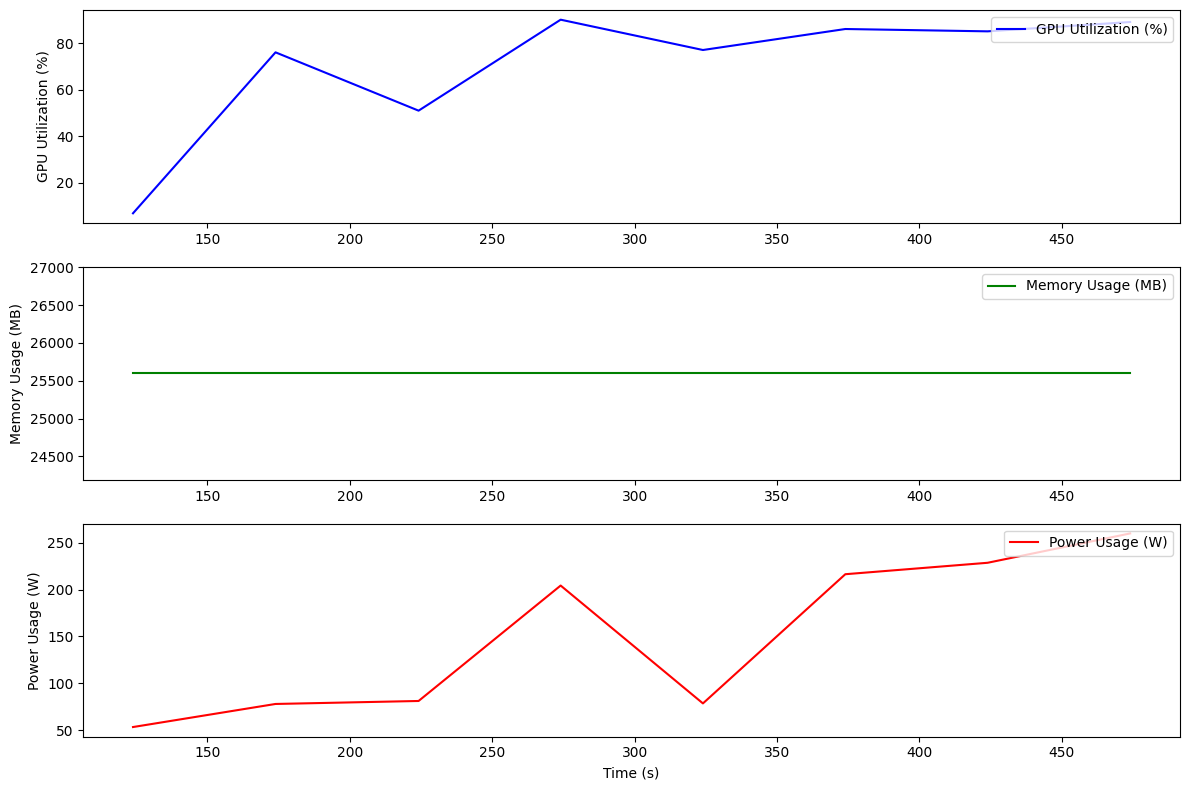

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback
import pynvml  # Import for GPU monitoring
import time
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import regularizers

# Custom DCT Layer
class DiscreteCosineLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(DiscreteCosineLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # inputs: [B,H,W,C]
        # DCT along width
        x = tf.transpose(inputs, [0,1,3,2])  # [B,H,C,W]
        x = tf.signal.dct(x, type=2, axis=-1, norm="ortho")
        x = tf.transpose(x, [0,1,3,2])       # [B,H,W,C]

        # DCT along height
        x = tf.transpose(x, [0,2,3,1])       # [B,W,C,H]
        x = tf.signal.dct(x, type=2, axis=-1, norm="ortho")
        x = tf.transpose(x, [0,3,1,2])       # [B,H,W,C]

        # Optional normalization to stabilize training
        mean = tf.reduce_mean(x, axis=[1,2,3], keepdims=True)
        std = tf.math.reduce_std(x, axis=[1,2,3], keepdims=True) + 1e-7
        x = (x - mean) / std

        return x

# Load CIFAR-100 from TFDS
(ds_train_dct, ds_val_dct, ds_test_dct), ds_info_dct = tfds.load(
    'cifar100',
    split=['train[:80%]', 'train[80%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

num_classes_dct = ds_info_dct.features['label'].num_classes

def preprocess_dct(image, label):
    # CIFAR-100 images are 32x32 RGB, need to be resized to 224x224 for ResNet
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(tf.cast(image, tf.float32))
    return image, label

batch_size_dct = 128

# Create the training, validation, and test datasets
ds_train_dct = ds_train_dct.map(preprocess_dct, num_parallel_calls=tf.data.AUTOTUNE)
ds_train_dct = ds_train_dct.shuffle(1024).batch(batch_size_dct).prefetch(tf.data.AUTOTUNE)

ds_val_dct = ds_val_dct.map(preprocess_dct, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_dct = ds_val_dct.batch(batch_size_dct).prefetch(tf.data.AUTOTUNE)

ds_test_dct = ds_test_dct.map(preprocess_dct, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_dct = ds_test_dct.batch(batch_size_dct).prefetch(tf.data.AUTOTUNE)

# GPU Monitoring Callback
class GPUMonitorCallback(Callback):
    def __init__(self):
        super().__init__()
        self.gpu_utilizations = []
        self.memory_usages = []
        self.power_usages = []
        self.timestamps = []
        self.start_time = None

        # Initialize NVML for GPU monitoring
        pynvml.nvmlInit()
        self.gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        # Record elapsed time
        elapsed_time = time.time() - self.start_time

        # Collect GPU metrics
        gpu_usage = pynvml.nvmlDeviceGetUtilizationRates(self.gpu_handle).gpu
        memory_details = pynvml.nvmlDeviceGetMemoryInfo(self.gpu_handle)
        memory_consumed = memory_details.used / 1024**2  # Convert to MB
        power_consumption = pynvml.nvmlDeviceGetPowerUsage(self.gpu_handle) / 1000  # Convert to Watts

        # Append metrics
        self.timestamps.append(elapsed_time)
        self.gpu_utilizations.append(gpu_usage)
        self.memory_usages.append(memory_consumed)
        self.power_usages.append(power_consumption)

        print(f"Epoch {epoch + 1}: GPU Utilization = {gpu_usage}%, Memory Usage = {memory_consumed:.2f} MB, Power Usage = {power_consumption:.2f} W")

    def plot_metrics(self):
        # Plot GPU Metrics
        plt.figure(figsize=(12, 8))

        # GPU Utilization Plot
        plt.subplot(3, 1, 1)
        plt.plot(self.timestamps, self.gpu_utilizations, label='GPU Utilization (%)', color='blue')
        plt.ylabel('GPU Utilization (%)')
        plt.legend(loc='upper right')

        # Memory Usage Plot
        plt.subplot(3, 1, 2)
        plt.plot(self.timestamps, self.memory_usages, label='Memory Usage (MB)', color='green')
        plt.ylabel('Memory Usage (MB)')
        plt.legend(loc='upper right')

        # Power Usage Plot
        plt.subplot(3, 1, 3)
        plt.plot(self.timestamps, self.power_usages, label='Power Usage (W)', color='red')
        plt.xlabel('Time (s)')
        plt.ylabel('Power Usage (W)')
        plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

    def on_train_end(self, logs=None):
        # Shutdown NVML after training
        pynvml.nvmlShutdown()

# Add custom DCT layer
inputs_dct = tf.keras.Input(shape=(224, 224, 3))
x_dct = DiscreteCosineLayer()(inputs_dct)  # Apply DCT

base_model_dct = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x_dct = base_model_dct.output
x_dct = GlobalAveragePooling2D()(x_dct)
x_dct = tf.keras.layers.Dropout(0.5)(x_dct)  # Dropout to reduce overfitting
outputs_dct = Dense(num_classes_dct, activation='softmax',
                   kernel_regularizer=regularizers.l2(1e-4))(x_dct)
model_dct = Model(inputs=base_model_dct.input, outputs=outputs_dct)

model_dct.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Initialize GPU Monitor Callback
gpu_monitor_dct = GPUMonitorCallback()

# Early Stopping Callback
early_stopping_dct = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Train the model with early stopping and GPU monitoring
history_dct = model_dct.fit(
    ds_train_dct,
    validation_data=ds_val_dct,
    epochs=50,  # set a higher number of epochs; early stopping will stop training earlier if no improvement
    callbacks=[early_stopping_dct, gpu_monitor_dct]
)

# Evaluate the model on the test set
model_dct.evaluate(ds_test_dct)

# Plot GPU metrics
gpu_monitor_dct.plot_metrics()



Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.0634 - loss: 4.2417Epoch 1: GPU Utilization=0%, Memory Usage=25613.19MB, Power=53.53W
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 170ms/step - accuracy: 0.0636 - loss: 4.2406 - val_accuracy: 0.0514 - val_loss: 4.3725
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.2040 - loss: 3.2471Epoch 2: GPU Utilization=80%, Memory Usage=25613.19MB, Power=274.90W
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.2040 - loss: 3.2468 - val_accuracy: 0.0839 - val_loss: 4.2483
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.2691 - loss: 2.9092Epoch 3: GPU Utilization=70%, Memory Usage=25613.19MB, Power=288.85W
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.2691 - loss: 2.9090 - val_accuracy: 0.2086 - val_loss: 3.2773
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3103 - loss: 2.6960Epoch 4: GPU Utilization=79%, Memory Usage=25613.19MB, Power=259.52W
313/313 ━━━━━━

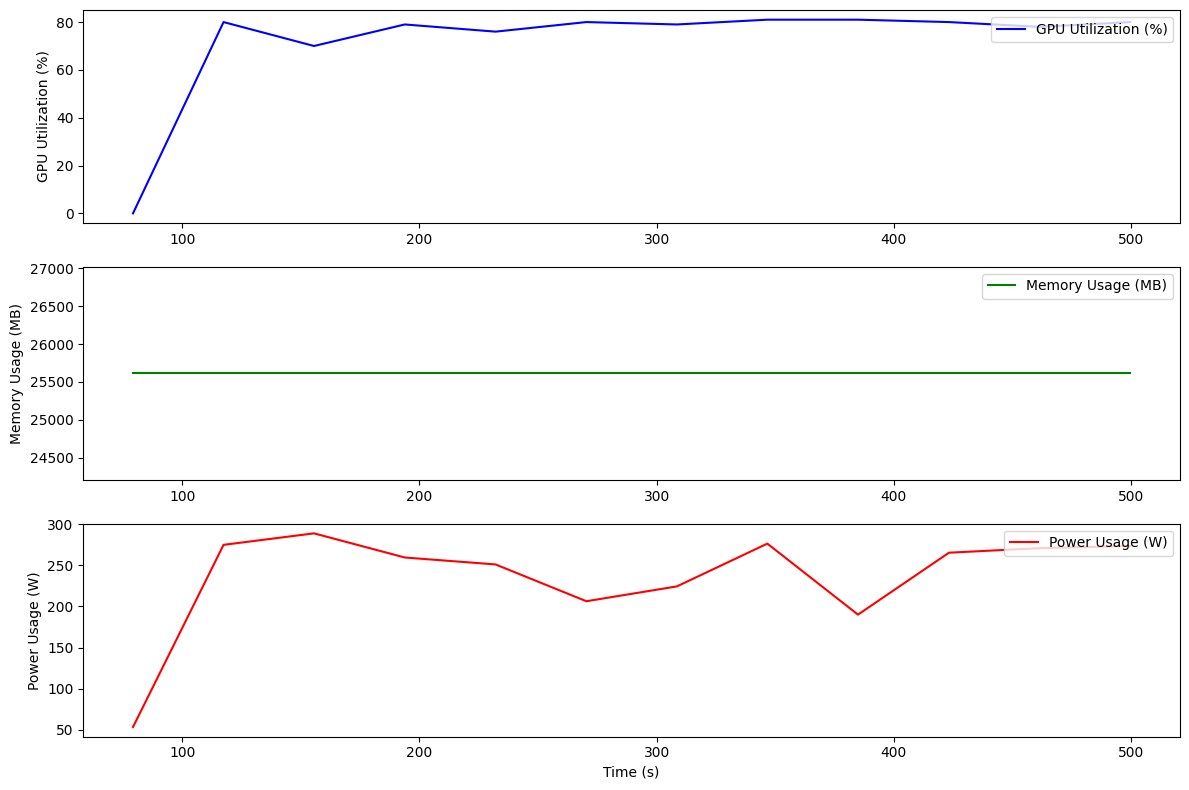

In [ ]:
#We can see that base DCT layer actually decreased the poewr consumption, now we are going to add multiple places

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.callbacks import Callback
import pynvml  # for GPU monitoring
import time
import matplotlib.pyplot as plt
import numpy as np

# Discrete Cosine Transform (DCT) Layer

class DiscreteCosineLayer(tf.keras.layers.Layer):
    """
    A custom Keras layer that applies a 2D Discrete Cosine Transform (DCT) to input tensors.
    This layer:
      - Performs DCT along both height and width axes.
      - Normalizes the transformed features by subtracting mean and dividing by std.
    """
    def __init__(self, **kwargs):
        super(DiscreteCosineLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # inputs shape: [B,H,W,C]

        # DCT along width
        x = tf.transpose(inputs, [0, 1, 3, 2])  # [B,H,C,W]
        x = tf.signal.dct(x, type=2, axis=-1, norm="ortho")
        x = tf.transpose(x, [0, 1, 3, 2])       # [B,H,W,C]

        # DCT along height
        x = tf.transpose(x, [0, 2, 3, 1])       # [B,W,C,H]
        x = tf.signal.dct(x, type=2, axis=-1, norm="ortho")
        x = tf.transpose(x, [0, 3, 1, 2])       # [B,H,W,C]

        # Normalization
        mean = tf.reduce_mean(x, axis=[1,2,3], keepdims=True)
        std = tf.math.reduce_std(x, axis=[1,2,3], keepdims=True) + 1e-7
        x = (x - mean) / std
        return x


# GPU Monitoring Callback

class GPUMonitorCallback(Callback):

    def __init__(self):
        super().__init__()
        self.gpu_utilizations = []
        self.memory_usages = []
        self.power_usages = []
        self.timestamps = []
        self.start_time = None

        # Initialize NVML for GPU monitoring
        pynvml.nvmlInit()
        self.gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time

        # Get GPU metrics
        gpu_usage = pynvml.nvmlDeviceGetUtilizationRates(self.gpu_handle).gpu
        memory_details = pynvml.nvmlDeviceGetMemoryInfo(self.gpu_handle)
        memory_consumed = memory_details.used / 1024**2  # MB
        power_consumption = pynvml.nvmlDeviceGetPowerUsage(self.gpu_handle) / 1000  # Watts

        # Store metrics
        self.timestamps.append(elapsed_time)
        self.gpu_utilizations.append(gpu_usage)
        self.memory_usages.append(memory_consumed)
        self.power_usages.append(power_consumption)

        print(f"Epoch {epoch+1}: GPU Utilization={gpu_usage}%, Memory Usage={memory_consumed:.2f}MB, Power={power_consumption:.2f}W")

    def on_train_end(self, logs=None):
        # Shutdown NVML after training
        pynvml.nvmlShutdown()

    def plot_metrics(self):
        # Plot GPU Metrics
        plt.figure(figsize=(12, 8))

        # GPU Utilization
        plt.subplot(3, 1, 1)
        plt.plot(self.timestamps, self.gpu_utilizations, label='GPU Utilization (%)', color='blue')
        plt.ylabel('GPU Utilization (%)')
        plt.legend(loc='upper right')

        # Memory Usage
        plt.subplot(3, 1, 2)
        plt.plot(self.timestamps, self.memory_usages, label='Memory Usage (MB)', color='green')
        plt.ylabel('Memory Usage (MB)')
        plt.legend(loc='upper right')

        # Power Usage
        plt.subplot(3, 1, 3)
        plt.plot(self.timestamps, self.power_usages, label='Power Usage (W)', color='red')
        plt.xlabel('Time (s)')
        plt.ylabel('Power Usage (W)')
        plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()


# Data Loading & Preprocessing

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'cifar100',
    split=['train[:80%]', 'train[80%:]', 'test'],
    as_supervised=True,
    with_info=True
)

num_classes = ds_info.features['label'].num_classes

def preprocess(image, label):
    # Resize CIFAR-100 (32x32) images to (224x224) for ResNet50
    # and apply ResNet50 preprocessing (which includes scaling)
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(tf.cast(image, tf.float32))
    return image, label

batch_size = 128

# Prepare training dataset
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Prepare validation dataset
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Prepare test dataset
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Model Construction with Multiple DCT Layers
# We create a model that:
# Takes input images and applies a DCT layer right after input.
# Passes the transformed input through ResNet50.
# Extracts an intermediate feature map from ResNet50.
# Applies another DCT layer to these intermediate features.
# Continues with GlobalAveragePooling and Dense output layers.

#Create an input layer
inputs = Input(shape=(224, 224, 3))

#Apply first DCT layer directly after input
x = DiscreteCosineLayer()(inputs)

#Load the ResNet50 base model without the top classification layer
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=x)

# Let's choose an intermediate layer output from ResNet50 for the second DCT.
# For example, 'conv3_block4_out' is an intermediate layer in ResNet50.
intermediate_layer_name = 'conv3_block4_out'
intermediate_output = base_model.get_layer(intermediate_layer_name).output

#Apply second DCT layer to intermediate features
x = DiscreteCosineLayer()(intermediate_output)

# After applying the second DCT layer, we can continue with more layers if desired.
# For simplicity, let's just proceed directly to GlobalAveragePooling.
x = GlobalAveragePooling2D()(x)

# Add Dropout to reduce overfitting
x = Dropout(0.5)(x)

#Output layer with L2 regularization
outputs = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

# Create final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training Setup
# GPU Monitoring Callback
gpu_monitor = GPUMonitorCallback()

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)


# Train the Model
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=100,
    callbacks=[early_stopping, gpu_monitor]
)


model.evaluate(ds_test)
gpu_monitor.plot_metrics()


Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.1688 - loss: 3.5675Epoch 1: GPU Utilization=4%, Memory Usage=25617.19MB, Power=53.20W
313/313 ━━━━━━━━━━━━━━━━━━━━ 117s 233ms/step - accuracy: 0.1691 - loss: 3.5656 - val_accuracy: 0.2694 - val_loss: 3.1695
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.4300 - loss: 2.1172Epoch 2: GPU Utilization=83%, Memory Usage=25617.19MB, Power=78.80W
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 144ms/step - accuracy: 0.4301 - loss: 2.1168 - val_accuracy: 0.4119 - val_loss: 2.3774
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5310 - loss: 1.6890Epoch 3: GPU Utilization=77%, Memory Usage=25617.19MB, Power=179.96W
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 143ms/step - accuracy: 0.5310 - loss: 1.6887 - val_accuracy: 0.4474 - val_loss: 2.3219
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5984 - loss: 1.4180Epoch 4: GPU Utilization=86%, Memory Usage=25617.19MB, Power=225.55W
313/313 ━━━━━━━━━━

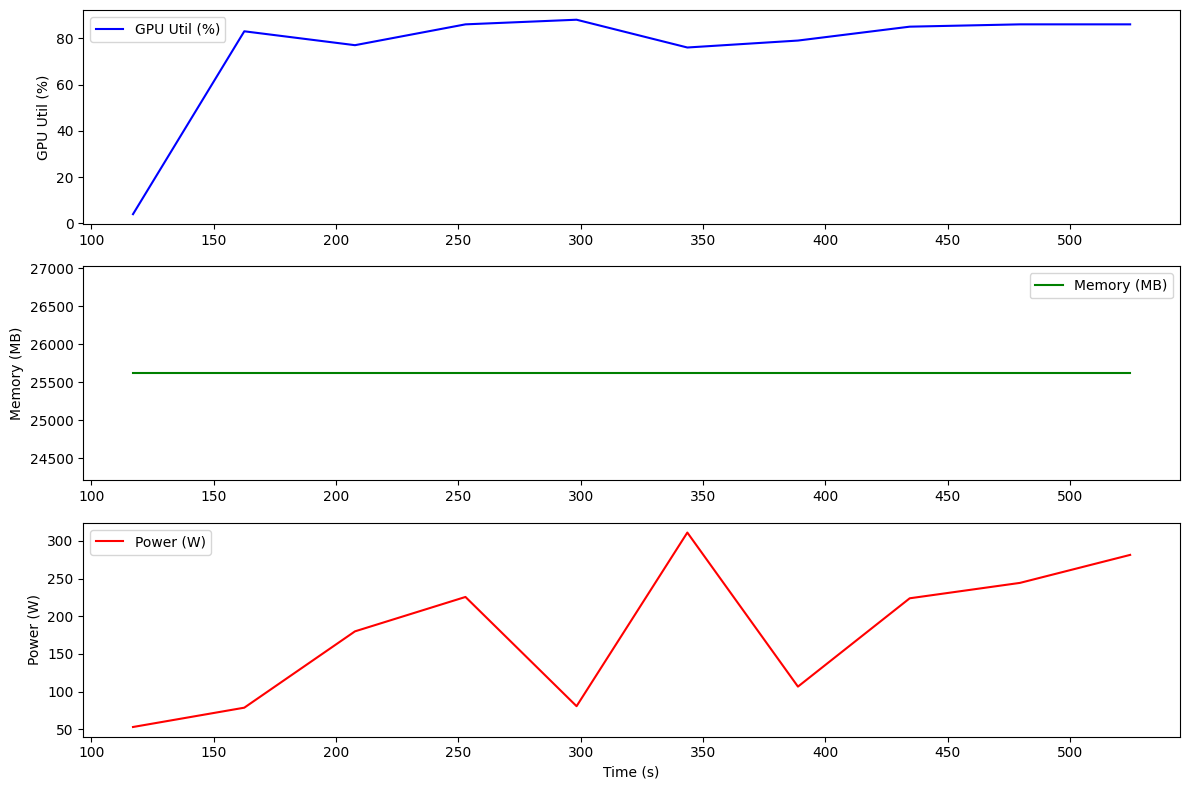

In [ ]:
#Above we are placing the First DCT Layer After Input
#Place the First DCT Layer After Early Convolutional Blocks
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.callbacks import Callback
import pynvml
import time
import matplotlib.pyplot as plt

# Discrete Cosine Transform (DCT) Layer
class DiscreteCosineLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(DiscreteCosineLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Perform 2D DCT along both height and width axes
        x = tf.transpose(inputs, [0, 1, 3, 2])  # [B, H, C, W]
        x = tf.signal.dct(x, type=2, axis=-1, norm="ortho")
        x = tf.transpose(x, [0, 1, 3, 2])  # [B, H, W, C]

        x = tf.transpose(x, [0, 2, 3, 1])  # [B, W, C, H]
        x = tf.signal.dct(x, type=2, axis=-1, norm="ortho")
        x = tf.transpose(x, [0, 3, 1, 2])  # [B, H, W, C]

        # Normalize the transformed data
        mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
        std = tf.math.reduce_std(x, axis=[1, 2, 3], keepdims=True) + 1e-7
        x = (x - mean) / std
        return x


# GPU Monitoring Callback (Optional)
class GPUMonitorCallback(Callback):
    def __init__(self):
        super().__init__()
        self.gpu_utilizations = []
        self.memory_usages = []
        self.power_usages = []
        self.timestamps = []
        self.start_time = None

        pynvml.nvmlInit()
        self.gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        gpu_usage = pynvml.nvmlDeviceGetUtilizationRates(self.gpu_handle).gpu
        memory_details = pynvml.nvmlDeviceGetMemoryInfo(self.gpu_handle)
        memory_consumed = memory_details.used / 1024**2  # MB
        power_consumption = pynvml.nvmlDeviceGetPowerUsage(self.gpu_handle) / 1000  # Watts

        self.timestamps.append(elapsed_time)
        self.gpu_utilizations.append(gpu_usage)
        self.memory_usages.append(memory_consumed)
        self.power_usages.append(power_consumption)

        print(f"Epoch {epoch + 1}: GPU Utilization={gpu_usage}%, Memory Usage={memory_consumed:.2f}MB, Power={power_consumption:.2f}W")

    def on_train_end(self, logs=None):
        pynvml.nvmlShutdown()

    def plot_metrics(self):
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(self.timestamps, self.gpu_utilizations, label="GPU Util (%)", color="blue")
        plt.ylabel("GPU Util (%)")
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(self.timestamps, self.memory_usages, label="Memory (MB)", color="green")
        plt.ylabel("Memory (MB)")
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(self.timestamps, self.power_usages, label="Power (W)", color="red")
        plt.xlabel("Time (s)")
        plt.ylabel("Power (W)")
        plt.legend()

        plt.tight_layout()
        plt.show()


# Load CIFAR-100 Dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    "cifar100", split=["train[:80%]", "train[80%:]", "test"], as_supervised=True, with_info=True
)

num_classes = ds_info.features["label"].num_classes

def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize to 224x224 for ResNet50
    image = preprocess_input(tf.cast(image, tf.float32))
    return image, label

batch_size = 128
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Model Construction
inputs = Input(shape=(224, 224, 3))

# Pass inputs through initial ResNet50 layers
base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

# Choose an early layer for the first DCT application
intermediate_layer_name = "conv2_block1_out"  # Early layer in ResNet50
intermediate_output = base_model.get_layer(intermediate_layer_name).output

# Apply the first DCT layer after an early convolutional block
x = DiscreteCosineLayer()(intermediate_output)

# Continue with deeper layers of ResNet50
x = base_model.get_layer("conv4_block6_out").output

# Global average pooling, dropout, and classification head
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation="softmax", kernel_regularizer=regularizers.l2(1e-4))(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Training Setup
gpu_monitor = GPUMonitorCallback()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

# Train the Model
history = model.fit(ds_train, validation_data=ds_val, epochs=50, callbacks=[early_stopping, gpu_monitor])

# Evaluate on Test Data
model.evaluate(ds_test)

# Plot GPU Monitoring Metrics
gpu_monitor.plot_metrics()



Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.0679 - loss: 4.1911Epoch 1: GPU Utilization=5%, Memory Usage=25621.19MB, Power=53.53W
313/313 ━━━━━━━━━━━━━━━━━━━━ 120s 234ms/step - accuracy: 0.0680 - loss: 4.1898 - val_accuracy: 0.0247 - val_loss: 4.8340
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2188 - loss: 3.1703Epoch 2: GPU Utilization=89%, Memory Usage=25621.19MB, Power=312.35W
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 151ms/step - accuracy: 0.2189 - loss: 3.1699 - val_accuracy: 0.0165 - val_loss: 5.0416
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2787 - loss: 2.8502Epoch 3: GPU Utilization=76%, Memory Usage=25621.19MB, Power=227.87W
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 151ms/step - accuracy: 0.2787 - loss: 2.8500 - val_accuracy: 0.1929 - val_loss: 3.3014
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.3288 - loss: 2.6176Epoch 4: GPU Utilization=88%, Memory Usage=25621.19MB, Power=299.60W
313/313 ━━━━━━━━━

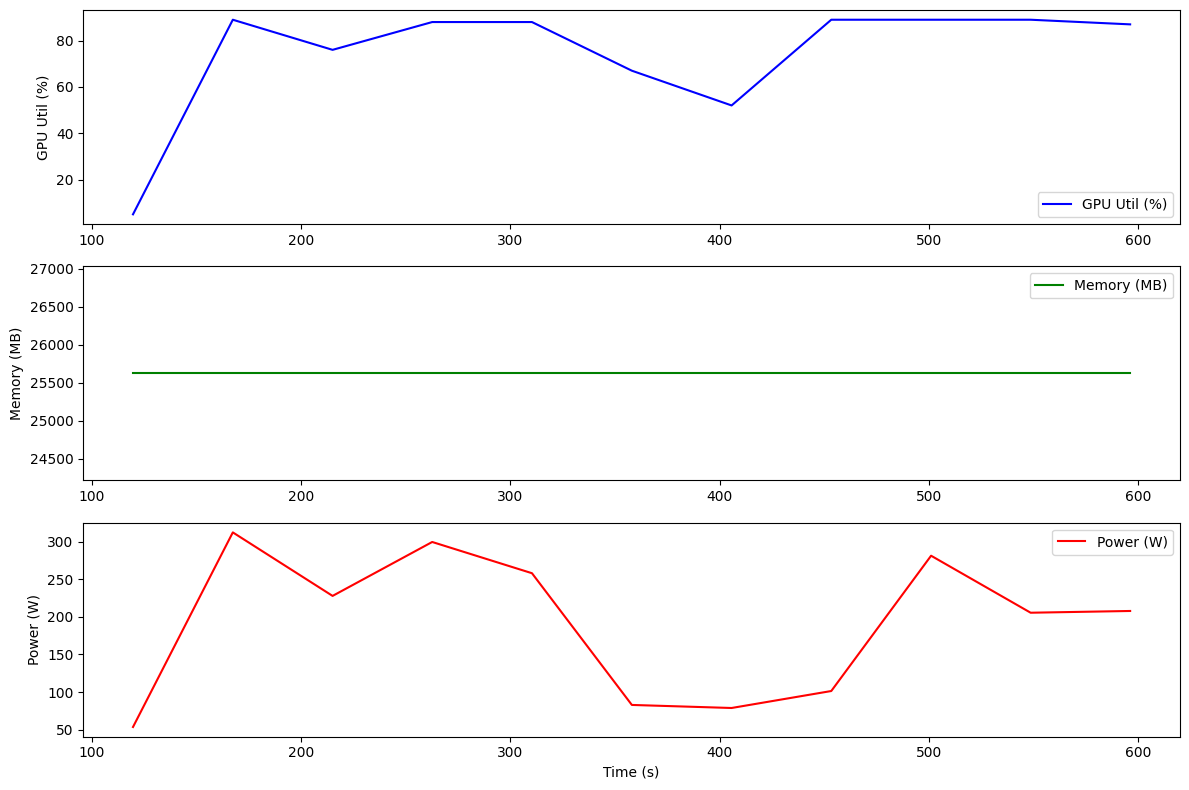

In [ ]:
#Third implementation
#Place the Second DCT Layer in Deeper Blocks

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.callbacks import Callback
import pynvml
import time
import matplotlib.pyplot as plt

# Discrete Cosine Transform (DCT) Layer
class DiscreteCosineLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(DiscreteCosineLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Perform 2D DCT along both height and width axes
        x = tf.transpose(inputs, [0, 1, 3, 2])  # [B, H, C, W]
        x = tf.signal.dct(x, type=2, axis=-1, norm="ortho")
        x = tf.transpose(x, [0, 1, 3, 2])  # [B, H, W, C]

        x = tf.transpose(x, [0, 2, 3, 1])  # [B, W, C, H]
        x = tf.signal.dct(x, type=2, axis=-1, norm="ortho")
        x = tf.transpose(x, [0, 3, 1, 2])  # [B, H, W, C]

        # Normalize the transformed data
        mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
        std = tf.math.reduce_std(x, axis=[1, 2, 3], keepdims=True) + 1e-7
        x = (x - mean) / std
        return x


# GPU Monitoring Callback (Optional)
class GPUMonitorCallback(Callback):
    def __init__(self):
        super().__init__()
        self.gpu_utilizations = []
        self.memory_usages = []
        self.power_usages = []
        self.timestamps = []
        self.start_time = None

        pynvml.nvmlInit()
        self.gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        gpu_usage = pynvml.nvmlDeviceGetUtilizationRates(self.gpu_handle).gpu
        memory_details = pynvml.nvmlDeviceGetMemoryInfo(self.gpu_handle)
        memory_consumed = memory_details.used / 1024**2  # MB
        power_consumption = pynvml.nvmlDeviceGetPowerUsage(self.gpu_handle) / 1000  # Watts

        self.timestamps.append(elapsed_time)
        self.gpu_utilizations.append(gpu_usage)
        self.memory_usages.append(memory_consumed)
        self.power_usages.append(power_consumption)

        print(f"Epoch {epoch + 1}: GPU Utilization={gpu_usage}%, Memory Usage={memory_consumed:.2f}MB, Power={power_consumption:.2f}W")

    def on_train_end(self, logs=None):
        pynvml.nvmlShutdown()

    def plot_metrics(self):
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(self.timestamps, self.gpu_utilizations, label="GPU Util (%)", color="blue")
        plt.ylabel("GPU Util (%)")
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(self.timestamps, self.memory_usages, label="Memory (MB)", color="green")
        plt.ylabel("Memory (MB)")
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(self.timestamps, self.power_usages, label="Power (W)", color="red")
        plt.xlabel("Time (s)")
        plt.ylabel("Power (W)")
        plt.legend()

        plt.tight_layout()
        plt.show()


# Load CIFAR-100 Dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    "cifar100", split=["train[:80%]", "train[80%:]", "test"], as_supervised=True, with_info=True
)

num_classes = ds_info.features["label"].num_classes

def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize to 224x224 for ResNet50
    image = preprocess_input(tf.cast(image, tf.float32))
    return image, label

batch_size = 128
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Model Construction
inputs = Input(shape=(224, 224, 3))

# Apply the first DCT layer after input
x = DiscreteCosineLayer()(inputs)

# ResNet50 Base
base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=x)

# Choose an intermediate layer for the second DCT
deeper_layer_name = "conv4_block6_out"  # Deeper block in ResNet50
intermediate_output = base_model.get_layer(deeper_layer_name).output

# Apply the second DCT layer after a deeper block
x = DiscreteCosineLayer()(intermediate_output)

# Global average pooling, dropout, and classification head
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation="softmax", kernel_regularizer=regularizers.l2(1e-4))(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Training Setup
gpu_monitor = GPUMonitorCallback()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

# Train the Model
history = model.fit(ds_train, validation_data=ds_val, epochs=50, callbacks=[early_stopping, gpu_monitor])

# Evaluate on Test Data
model.evaluate(ds_test)

# Plot GPU Monitoring Metrics
gpu_monitor.plot_metrics()



Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0430 - loss: 4.3047Epoch 1: GPU Utilization=3%, Memory Usage=25623.19MB, Power=53.20W
313/313 ━━━━━━━━━━━━━━━━━━━━ 113s 227ms/step - accuracy: 0.0431 - loss: 4.3040 - val_accuracy: 0.0775 - val_loss: 4.0855
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.1386 - loss: 3.5295Epoch 2: GPU Utilization=83%, Memory Usage=25623.19MB, Power=78.13W
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 149ms/step - accuracy: 0.1387 - loss: 3.5291 - val_accuracy: 0.1201 - val_loss: 3.8834
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2292 - loss: 3.0107Epoch 3: GPU Utilization=80%, Memory Usage=25623.19MB, Power=78.80W
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 150ms/step - accuracy: 0.2292 - loss: 3.0105 - val_accuracy: 0.2323 - val_loss: 3.0414
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3012 - loss: 2.6639Epoch 4: GPU Utilization=60%, Memory Usage=25623.19MB, Power=80.86W
313/313 ━━━━━━━━━━━━

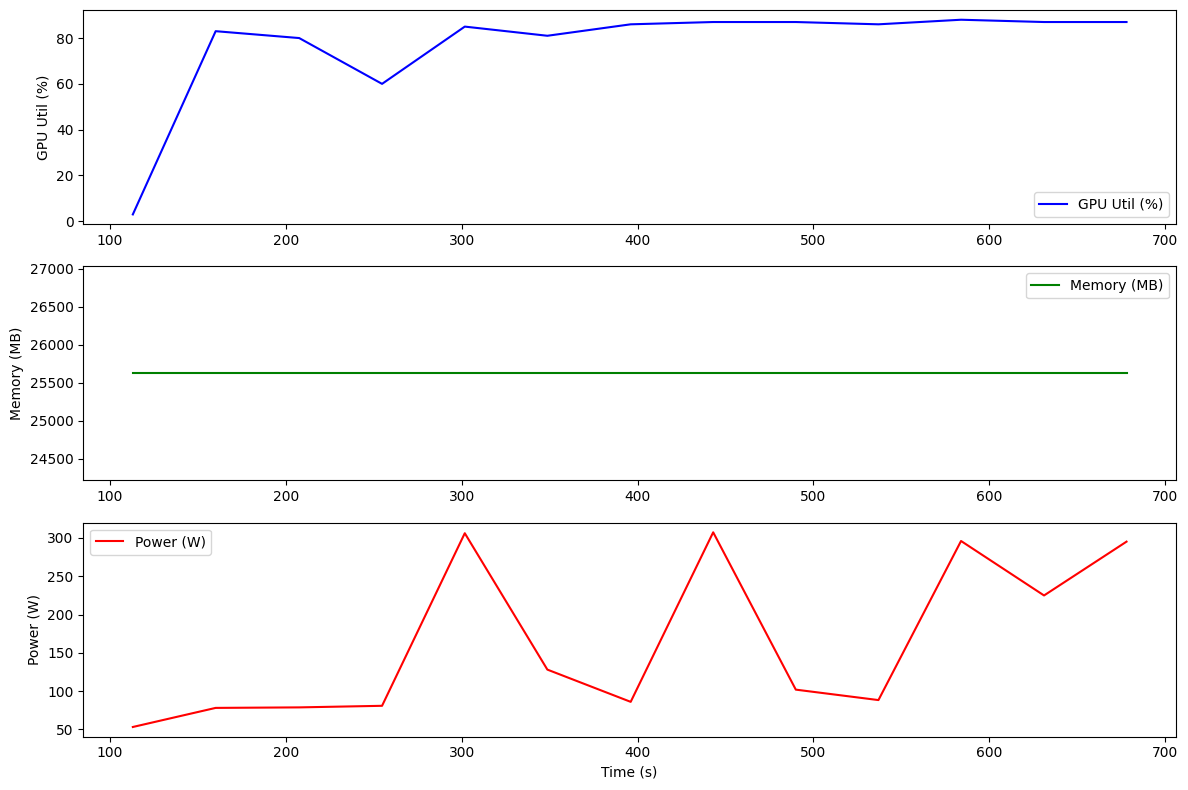

In [ ]:
#Adding DCT Layers in Both Early and Late Stages

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.callbacks import Callback
import pynvml
import time
import matplotlib.pyplot as plt

# Discrete Cosine Transform (DCT) Layer
class DiscreteCosineLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(DiscreteCosineLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Perform 2D DCT along both height and width axes
        x = tf.transpose(inputs, [0, 1, 3, 2])  # [B, H, C, W]
        x = tf.signal.dct(x, type=2, axis=-1, norm="ortho")
        x = tf.transpose(x, [0, 1, 3, 2])  # [B, H, W, C]

        x = tf.transpose(x, [0, 2, 3, 1])  # [B, W, C, H]
        x = tf.signal.dct(x, type=2, axis=-1, norm="ortho")
        x = tf.transpose(x, [0, 3, 1, 2])  # [B, H, W, C]

        # Normalize the transformed data
        mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
        std = tf.math.reduce_std(x, axis=[1, 2, 3], keepdims=True) + 1e-7
        x = (x - mean) / std
        return x


# GPU Monitoring Callback (Optional)
class GPUMonitorCallback(Callback):
    def __init__(self):
        super().__init__()
        self.gpu_utilizations = []
        self.memory_usages = []
        self.power_usages = []
        self.timestamps = []
        self.start_time = None

        pynvml.nvmlInit()
        self.gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        gpu_usage = pynvml.nvmlDeviceGetUtilizationRates(self.gpu_handle).gpu
        memory_details = pynvml.nvmlDeviceGetMemoryInfo(self.gpu_handle)
        memory_consumed = memory_details.used / 1024**2  # MB
        power_consumption = pynvml.nvmlDeviceGetPowerUsage(self.gpu_handle) / 1000  # Watts

        self.timestamps.append(elapsed_time)
        self.gpu_utilizations.append(gpu_usage)
        self.memory_usages.append(memory_consumed)
        self.power_usages.append(power_consumption)

        print(f"Epoch {epoch + 1}: GPU Utilization={gpu_usage}%, Memory Usage={memory_consumed:.2f}MB, Power={power_consumption:.2f}W")

    def on_train_end(self, logs=None):
        pynvml.nvmlShutdown()

    def plot_metrics(self):
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(self.timestamps, self.gpu_utilizations, label="GPU Util (%)", color="blue")
        plt.ylabel("GPU Util (%)")
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(self.timestamps, self.memory_usages, label="Memory (MB)", color="green")
        plt.ylabel("Memory (MB)")
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(self.timestamps, self.power_usages, label="Power (W)", color="red")
        plt.xlabel("Time (s)")
        plt.ylabel("Power (W)")
        plt.legend()

        plt.tight_layout()
        plt.show()


# Load CIFAR-100 Dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    "cifar100", split=["train[:80%]", "train[80%:]", "test"], as_supervised=True, with_info=True
)

num_classes = ds_info.features["label"].num_classes

def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize to 224x224 for ResNet50
    image = preprocess_input(tf.cast(image, tf.float32))
    return image, label

batch_size = 128
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Model Construction
inputs = Input(shape=(224, 224, 3))

# ResNet50 Base
base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

# Apply the first DCT layer at an early stage
early_layer_name = "conv2_block1_out"  # Early block in ResNet50
early_output = base_model.get_layer(early_layer_name).output
x = DiscreteCosineLayer()(early_output)

# Continue with deeper layers
deeper_layer_name = "conv4_block6_out"  # Deeper block in ResNet50
deeper_output = base_model.get_layer(deeper_layer_name).output

# Apply the second DCT layer to deeper features
x = DiscreteCosineLayer()(deeper_output)

# Global average pooling, dropout, and classification head
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation="softmax", kernel_regularizer=regularizers.l2(1e-4))(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Training Setup
gpu_monitor = GPUMonitorCallback()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

# Train the Model
history = model.fit(ds_train, validation_data=ds_val, epochs=50, callbacks=[early_stopping, gpu_monitor])

# Evaluate on Test Data
model.evaluate(ds_test)

# Plot GPU Monitoring Metrics
gpu_monitor.plot_metrics()
